In [ ]:
import pandas as pd
import numpy as np
import io
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import ray
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from ray import tune # Import tune
from ray.tune.schedulers import ASHAScheduler # Optional: for early stopping
import ray
from ray.train import Checkpoint, CheckpointConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchTrainer

In [2]:
# Initialize Ray if not already initialized
if not ray.is_initialized():
    ray.init()

2025-06-14 04:05:50,810	INFO worker.py:1888 -- Started a local Ray instance.


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

output_dir = "/kaggle/working/ray_results"

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


In [11]:
df = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')


# Select the first 10 rows
head_df = df.head(10)
display(HTML(head_df.to_html()))

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP
5,5,30,59,29,Red,Pulses,10,0,9,20-20
6,6,27,62,53,Sandy,Paddy,26,15,22,28-28
7,7,36,62,44,Red,Pulses,30,12,35,14-35-14
8,8,36,51,32,Loamy,Tobacco,19,17,29,17-17-17
9,9,28,50,35,Red,Tobacco,25,12,16,20-20


In [12]:
# drop 'id' index
df = df.drop(columns=['id'])

print(df.head())

   Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  Potassium  \
0           37        70        36    Clayey  Sugarcane        36          4   
1           27        69        65     Sandy    Millets        30          6   
2           29        63        32     Sandy    Millets        24         12   
3           35        62        54     Sandy     Barley        39         12   
4           35        58        43       Red      Paddy        37          2   

   Phosphorous Fertilizer Name  
0            5           28-28  
1           18           28-28  
2           16        17-17-17  
3            4        10-26-26  
4           16             DAP  


In [13]:
print("DataFrame Shape:")
print(df.shape)

print("\nDataFrame Info:")
df.info()

print("\nDataFrame Descriptive Statistics (Numerical Columns):")
print(df.describe())

print("\nValue Counts for Categorical Columns:")
print("Soil_Type:\n", df['Soil Type'].value_counts())
print("\nCrop_Type:\n", df['Crop Type'].value_counts())
print("\nFertilizer_Name:\n", df['Fertilizer Name'].value_counts())
print("\n" + "="*50 + "\n")

DataFrame Shape:
(750000, 9)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      750000 non-null  int64 
 1   Humidity         750000 non-null  int64 
 2   Moisture         750000 non-null  int64 
 3   Soil Type        750000 non-null  object
 4   Crop Type        750000 non-null  object
 5   Nitrogen         750000 non-null  int64 
 6   Potassium        750000 non-null  int64 
 7   Phosphorous      750000 non-null  int64 
 8   Fertilizer Name  750000 non-null  object
dtypes: int64(6), object(3)
memory usage: 51.5+ MB

DataFrame Descriptive Statistics (Numerical Columns):
         Temparature       Humidity       Moisture       Nitrogen  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       31.503565      61.038912      45.184147      23.093808   
std         4.025574     

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

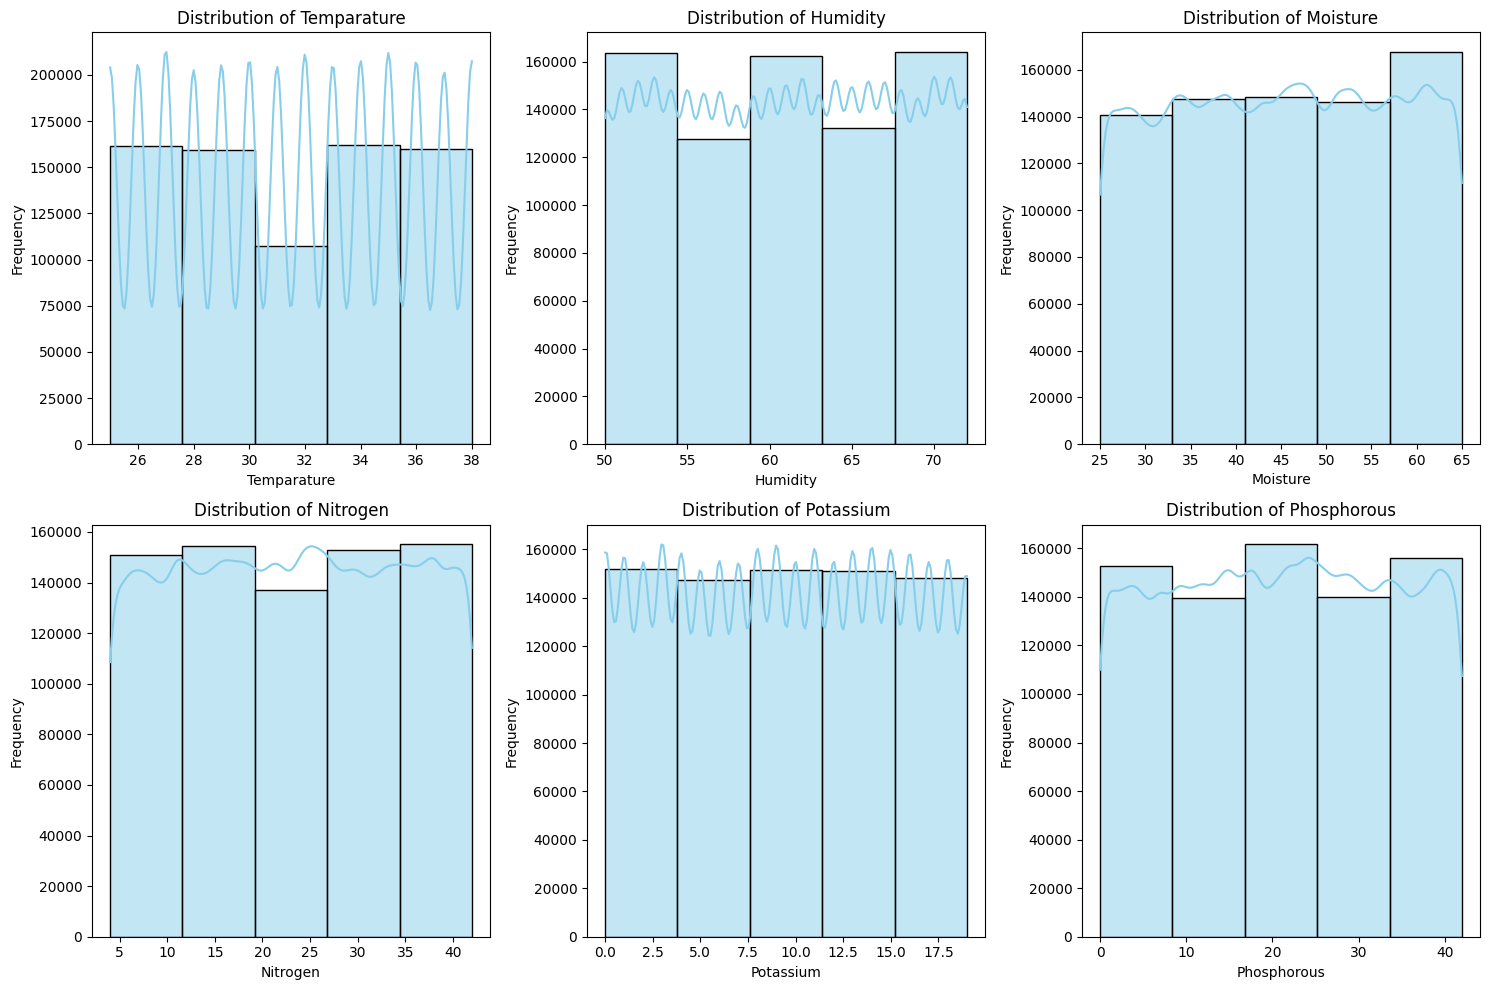

In [14]:
# Select numerical columns for plotting
numerical_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=5, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [15]:
# Add features
def add_features(df):
    # --- 1. Nutrient Ratios and Totals ---
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-6
    df['NP_Ratio'] = df['Nitrogen'] / (df['Phosphorous'] + epsilon)
    df['NK_Ratio'] = df['Nitrogen'] / (df['Potassium'] + epsilon)
    df['PK_Ratio'] = df['Phosphorous'] / (df['Potassium'] + epsilon)
    
    df['Total_NPK'] = df['Nitrogen'] + df['Potassium'] + df['Phosphorous']
    
    # Handle cases where Total_NPK might be zero for percentage calculation
    total_npk_safe = df['Total_NPK'].replace(0, epsilon)
    df['N_Percentage'] = df['Nitrogen'] / total_npk_safe
    df['P_Percentage'] = df['Phosphorous'] / total_npk_safe
    df['K_Percentage'] = df['Potassium'] / total_npk_safe
    
    # --- 2. Environmental Interactions ---
    df['Temp_Moisture_Interaction'] = df['Temparature'] * df['Moisture']
    df['Temp_Humidity_Interaction'] = df['Temparature'] * df['Moisture']
    df['Hum_Moisture_Interaction'] = df['Humidity'] * df['Moisture']
    
    # --- 3. Polynomial Features ---
    df['Temperature_Squared'] = df['Temparature']**2
    df['Humidity_Squared'] = df['Humidity']**2
    df['Moisture_Squared'] = df['Moisture']**2
    return df

In [16]:
df = add_features(df)

# Preprocessing
# Define the target column
TARGET_COLUMN = 'Fertilizer Name'

# Define numerical and categorical features (excluding 'id' and the target)
NUMERICAL_COLS = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous', 
                  'NP_Ratio', 'NK_Ratio', 'PK_Ratio', 'Total_NPK', 
                  'N_Percentage','P_Percentage', 'K_Percentage', 
                  'Temp_Moisture_Interaction', 'Temp_Humidity_Interaction', 'Hum_Moisture_Interaction',
                  'Temperature_Squared', 'Humidity_Squared', 'Moisture_Squared'
                 ]
CATEGORICAL_COLS = ['Soil Type', 'Crop Type']

# Separate features (X) and target (y)
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# --- Target Encoding ---
# Encode the target variable 'Fertilizer Name' into numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
NUM_CLASSES = len(label_encoder.classes_) # Global variable for num_classes
print(f"Detected {NUM_CLASSES} unique fertilizer names: {label_encoder.classes_}")

# --- Feature Preprocessing (One-Hot Encoding for categorical) ---
# --- Feature Preprocessing with Scaling for numerical ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(feature_range=(-1, 1)), NUMERICAL_COLS), # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_COLS)
    ],
    remainder='drop' # Drop any columns not explicitly transformed (like 'id' if it wasn't dropped already)
)

# Fit and transform the features
X_processed = preprocessor.fit_transform(X)

# Determine the input size for the model based on the processed features
INPUT_SIZE = X_processed.shape[1] # Global variable for input_size
print(f"Input feature size after preprocessing: {INPUT_SIZE}")

# Combine processed features and encoded labels into a DataFrame for Ray Dataset
# We convert the sparse matrix from OneHotEncoder to a dense array for easier handling.
processed_data_for_ray = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed,
                                      columns=[f'feature_{i}' for i in range(INPUT_SIZE)])
processed_data_for_ray['labels'] = y_encoded

# Convert Pandas DataFrame to Ray Dataset
# The `map_batches` step ensures the dataset yields dictionaries with 'features' (NumPy array)
# and 'labels' (NumPy array) as expected by iter_torch_batches.
ray_dataset = ray.data.from_pandas(processed_data_for_ray)

# Transform the Ray Dataset to have 'features' (all input columns as a single array) and 'labels'
ray_dataset = ray_dataset.map_batches(
    lambda batch: {
        "features": batch[[col for col in batch.columns if col.startswith('feature_')]].values.astype(np.float32),
        "labels": batch["labels"].values.astype(np.int64) # Labels should be int64 for PyTorch LongTensor
    },
    batch_format="pandas" # Process batches as Pandas DataFrames
)

# --- Split the Ray Dataset into Train and Test ---
# Use .train_test_split() with a test_size of 0.2 (20%)
# random_state ensures reproducibility of the split.
train_ray_dataset, test_ray_dataset = ray_dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)

print(f"\nTotal Ray Dataset created with {ray_dataset.count()} rows.")
print(f"Train Ray Dataset created with {train_ray_dataset.count()} rows (80%).")
print(f"Test Ray Dataset created with {test_ray_dataset.count()} rows (20%).")

# Example of peeking into the train dataset to verify structure and data types
print("\n--- Sample from Training Dataset ---")
for i, row in enumerate(train_ray_dataset.take(1)): # Take only 1 for brevity
    label_dtype = getattr(row['labels'], 'dtype', type(row['labels']).__name__)
    print(f"Sample {i+1}: Features shape {row['features'].shape}, Features dtype: {row['features'].dtype}, Label: {row['labels']}, Label dtype: {label_dtype}")
    print(f"Sample {i+1} Features (first 5 elements): {row['features'][:5]}")

Detected 7 unique fertilizer names: ['10-26-26' '14-35-14' '17-17-17' '20-20' '28-28' 'DAP' 'Urea']
Input feature size after preprocessing: 35


2025-06-14 04:08:01,282	INFO logging.py:290 -- Registered dataset logger for dataset dataset_3_0
2025-06-14 04:08:01,379	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_3_0. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
2025-06-14 04:08:01,380	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_3_0: InputDataBuffer[Input] -> AllToAllOperator[MapBatches(<lambda>)->RandomShuffle] -> AggregateNumRows[AggregateNumRows]


Running 0:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(<lambda>)->RandomShuffle 1: 0.00 row [00:00, ? row/s]

Shuffle Map 2:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- AggregateNumRows 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

2025-06-14 04:08:03,755	INFO streaming_executor.py:220 -- ✔️  Dataset dataset_3_0 execution finished in 2.37 seconds
2025-06-14 04:08:03,796	INFO logging.py:290 -- Registered dataset logger for dataset dataset_2_0
2025-06-14 04:08:03,798	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_2_0. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
2025-06-14 04:08:03,799	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_2_0: InputDataBuffer[Input] -> AllToAllOperator[MapBatches(<lambda>)->RandomShuffle]


Running 0: 0.00 row [00:00, ? row/s]

- MapBatches(<lambda>)->RandomShuffle 1: 0.00 row [00:00, ? row/s]

Shuffle Map 2:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

2025-06-14 04:08:05,948	INFO streaming_executor.py:220 -- ✔️  Dataset dataset_2_0 execution finished in 2.15 seconds
2025-06-14 04:08:06,179	INFO logging.py:290 -- Registered dataset logger for dataset dataset_6_0
2025-06-14 04:08:06,181	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_6_0. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
2025-06-14 04:08:06,182	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_6_0: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> AggregateNumRows[AggregateNumRows]


Running 0:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(<lambda>) 1: 0.00 row [00:00, ? row/s]

- AggregateNumRows 2:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

2025-06-14 04:08:06,733	INFO streaming_executor.py:220 -- ✔️  Dataset dataset_6_0 execution finished in 0.55 seconds
2025-06-14 04:08:06,745	INFO dataset.py:3027 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-06-14 04:08:06,748	INFO logging.py:290 -- Registered dataset logger for dataset dataset_7_0
2025-06-14 04:08:06,750	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_7_0. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
2025-06-14 04:08:06,750	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_7_0: InputDataBuffer[Input] -> LimitOperator[limit=1]



Total Ray Dataset created with 750000 rows.
Train Ray Dataset created with 600000 rows (80%).
Test Ray Dataset created with 150000 rows (20%).

--- Sample from Training Dataset ---


Running 0: 0.00 row [00:00, ? row/s]

- limit=1 1: 0.00 row [00:00, ? row/s]

2025-06-14 04:08:06,796	INFO streaming_executor.py:220 -- ✔️  Dataset dataset_7_0 execution finished in 0.05 seconds


Sample 1: Features shape (35,), Features dtype: float32, Label: 0, Label dtype: int
Sample 1 Features (first 5 elements): [ 0.53846157 -0.27272728 -0.35        0.6315789  -0.57894737]


In [17]:
# Split the Ray Dataset into 80% training and 20% testing sets
train_dataset, test_dataset = ray_dataset.train_test_split(test_size=0.2, shuffle=True)

print(f"Ray Dataset split into training and testing sets:")
print(f"  Training dataset size: {train_dataset.count()} samples")
print(f"  Testing dataset size: {test_dataset.count()} samples")
print("\n" + "="*50 + "\n")

2025-06-14 04:08:11,784	INFO logging.py:290 -- Registered dataset logger for dataset dataset_9_0
2025-06-14 04:08:11,787	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_9_0. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
2025-06-14 04:08:11,788	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_9_0: InputDataBuffer[Input] -> AllToAllOperator[MapBatches(<lambda>)->RandomShuffle] -> AggregateNumRows[AggregateNumRows]


Running 0:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(<lambda>)->RandomShuffle 1: 0.00 row [00:00, ? row/s]

Shuffle Map 2:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- AggregateNumRows 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

2025-06-14 04:08:13,919	INFO streaming_executor.py:220 -- ✔️  Dataset dataset_9_0 execution finished in 2.13 seconds
2025-06-14 04:08:13,936	INFO logging.py:290 -- Registered dataset logger for dataset dataset_8_0
2025-06-14 04:08:13,939	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_8_0. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
2025-06-14 04:08:13,940	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_8_0: InputDataBuffer[Input] -> AllToAllOperator[MapBatches(<lambda>)->RandomShuffle]


Running 0: 0.00 row [00:00, ? row/s]

- MapBatches(<lambda>)->RandomShuffle 1: 0.00 row [00:00, ? row/s]

Shuffle Map 2:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

2025-06-14 04:08:16,089	INFO streaming_executor.py:220 -- ✔️  Dataset dataset_8_0 execution finished in 2.15 seconds


Ray Dataset split into training and testing sets:
  Training dataset size: 600000 samples
  Testing dataset size: 150000 samples




In [18]:
# 3. Define the PyTorch Model
class FertilizerClassifier(nn.Module):
    def __init__(self, input_size, num_classes, l1_units, l2_units, dropout_rate, activation_fn_name):
        super().__init__()
        self.fc1 = nn.Linear(input_size, l1_units)
        self.bn1 = nn.BatchNorm1d(l1_units) # Good practice to include BatchNorm

        self.fc2 = nn.Linear(l1_units, l2_units)
        self.bn2 = nn.BatchNorm1d(l2_units)

        self.fc3 = nn.Linear(l2_units, num_classes) # Final layer

        self.dropout = nn.Dropout(dropout_rate)

        # Select activation function based on string name
        if activation_fn_name == "relu":
            self.activation = nn.ReLU()
        elif activation_fn_name == "leaky_relu":
            self.activation = nn.LeakyReLU()
        elif activation_fn_name == "elu":
            self.activation = nn.ELU()
        else:
            raise ValueError(f"Unknown activation function: {activation_fn_name}")

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x) # Output logits
        return x

In [ ]:
# 4. Wrap Training Logic for Ray Tune
# The 'config' dictionary will contain the hyperparameters sampled by Tune.
def train_func_with_tune(config):
    # Retrieve hyperparameters from config
    lr = config["lr"]
    num_epochs = config["num_epochs"] # Can also be a hyperparameter

    # Access the dataset shards
    # ray.train.get_dataset_shard() works within ray.train, which TorchTrainer uses.
    # TorchTrainer is launched by Tune when used with tune.Tuner().
    train_data_shard = ray.train.get_dataset_shard("train")
    test_data_shard = ray.train.get_dataset_shard("test") # For validation/reporting

    global INPUT_SIZE, NUM_CLASSES # Access global model dimensions

    # Instantiate the model with hyperparameters from 'config'
    model = FertilizerClassifier(
        input_size=config["input_size"],
        num_classes=config["num_classes"],
        l1_units=config["l1_units"],
        l2_units=config["l2_units"],
        dropout_rate=config["dropout_rate"],
        activation_fn_name=config["activation_fn"]
    )

    # Choose optimizer based on config
    if config["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    elif config["optimizer"] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9, weight_decay=config["weight_decay"])
    else:
        raise ValueError(f"Unknown optimizer: {config['optimizer']}")

    loss_fn = nn.CrossEntropyLoss()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        # --- Training Loop ---
        model.train()
        total_train_loss = 0
        num_train_batches = 0
        for batch in train_data_shard.iter_torch_batches(batch_size=16, dtypes=torch.float32):
            features = batch["features"].to(device)
            labels = batch["labels"].long().to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            num_train_batches += 1
        
        avg_train_loss = total_train_loss / num_train_batches

        # --- Validation Loop (using test_data_shard) ---
        model.eval() # Set model to evaluation mode
        total_correct = 0
        total_samples = 0
        total_val_loss = 0
        num_val_batches = 0

        with torch.no_grad(): # Disable gradient calculations
            for batch in test_data_shard.iter_torch_batches(batch_size=16, dtypes=torch.float32):
                features = batch["features"].to(device)
                labels = batch["labels"].long().to(device)

                outputs = model(features)
                val_loss = loss_fn(outputs, labels) # Calculate validation loss
                
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()
                total_val_loss += val_loss.item()
                num_val_batches += 1

        accuracy = total_correct / total_samples if total_samples > 0 else 0
        avg_val_loss = total_val_loss / num_val_batches if num_val_batches > 0 else 0

        print(f"Worker {ray.train.get_context().get_local_rank()} - Epoch {epoch+1}, "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        # Report metrics to Ray Tune
        ray.train.report(metrics={"loss": avg_train_loss, "val_loss": avg_val_loss, "accuracy": accuracy})

# 5. Define the Search Space for Hyperparameters
search_space = {
    "input_size": tune.grid_search([INPUT_SIZE]), # Fixed based on your data
    "num_classes": tune.grid_search([NUM_CLASSES]), # Fixed based on your data
    "lr": tune.loguniform(1e-4, 1e-2), # Sample learning rate logarithmically between 0.0001 and 0.01
    "batch_size": tune.choice([16, 32, 64, 128]),
    "dropout_rate": tune.uniform(0.1, 0.5),
    "weight_decay": tune.loguniform(1e-5, 1e-3),
    "activation_fn": tune.choice(["relu", "leaky_relu", "elu"]),
    "l1_units": tune.choice([64, 128, 256]),
    "l2_units": tune.choice([32, 64, 128]),
    "optimizer": tune.choice(["Adam", "SGD"]),
    "num_epochs": 30 # Fixed number of epochs for each trial for simplicity
}

USE_GPU = False
if torch.cuda.is_available():
    print("GPU is available!!!!")
    USE_GPU = True

# 6. Configure and Run Ray Tune
# Use TorchTrainer within the tune.Tuner

if USE_GPU:
    trainable = TorchTrainer(
        train_loop_per_worker=train_func_with_tune,
        scaling_config=ScalingConfig(num_workers=2, use_gpu=USE_GPU, resources_per_worker={"CPU": 1, "GPU": 1}),
        datasets={"train": train_ray_dataset, "test": test_ray_dataset} # Pass both datasets
    )
else:
    trainable = TorchTrainer(
        train_loop_per_worker=train_func_with_tune,
        scaling_config=ScalingConfig(num_workers=2, use_gpu=USE_GPU),
        datasets={"train": train_ray_dataset, "test": test_ray_dataset} # Pass both datasets
    )

# Optional: Define a scheduler for early stopping (e.g., ASHA)
# This helps stop bad performing trials early to save resources.
scheduler = ASHAScheduler(
    metric="val_loss", # Metric to monitor for early stopping
    mode="min",        # We want to minimize validation loss
    max_t=30,          # Max epochs per trial (should match num_epochs in config)
    grace_period=1,    # Don't stop trials before 1 epoch
    reduction_factor=2 # Factor for reducing active trials
)

tuner = tune.Tuner(
    trainable,
    param_space={"train_loop_config": search_space},
    tune_config=tune.TuneConfig(
        num_samples=6,     # Number of different hyperparameter combinations to try
        scheduler=scheduler # Apply the scheduler
    ),
    run_config=RunConfig(
        name="torch_trainer_experiment",
        storage_path=output_dir, # Set the desired output directory
        checkpoint_config=tune.CheckpointConfig(
            checkpoint_score_attribute="loss", # Metric to use for best checkpoint
            checkpoint_score_order="min",     # Smaller loss is better
            num_to_keep=1,                    # Only keep the single best checkpoint
        ),
    ),
)

# Run the tuning experiment
results = tuner.fit()

# Get the best trial
best_result = results.get_best_result("val_loss", "min")

print(f"\nBest trial found: {best_result.config}")
print(f"Best trial final validation loss: {best_result.metrics['val_loss']:.4f}")
print(f"Best trial final accuracy: {best_result.metrics['accuracy']:.4f}")

# You can also access the best model checkpoint if you configured checkpointing in your train_func_with_tune
if best_result.path:
    print(f"Best trial checkpoint path: {best_result.path}")
    # You would load the model from this checkpoint for inference
    loaded_model = FertilizerClassifier(INPUT_SIZE, NUM_CLASSES)
    loaded_model.load_state_dict(torch.load(os.path.join(best_result.checkpoint.path, "model.pt")))


(RayTrainWorker pid=764) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=763) [W614 04:08:53.360064135 socket.cpp:204] [c10d] The hostname of the client socket cannot be retrieved. err=-3
(RayTrainWorker pid=764) [W614 04:09:03.404181916 socket.cpp:204] [c10d] The hostname of the client socket cannot be retrieved. err=-3 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(RayTrainWorker pid=764) [W614 04:09:14.453070485 socket.cpp:204] [c10d] The hostname of the client socket cannot be retrieved. err=-3
(TorchTrainer pid=719) Started distributed worker processes: 
(TorchTrainer pid=719) - (node_id=d8f3c1a855c2baf292a5430fd348cd6bd186f1851b65a39da5ab5978, ip=172.19.2.2, pid=764) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=719) - (node_id=d8f3c1a855c2baf2

(pid=845) Running 0: 0.00 row [00:00, ? row/s]

(pid=845) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(pid=844) Running 0: 0.00 row [00:00, ? row/s]

(pid=844) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=844) Registered dataset logger for dataset test_13_0
(SplitCoordinator pid=844) Starting execution of Dataset test_13_0. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=844) Execution plan of Dataset test_13_0: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=844) ✔️  Dataset test_13_0 execution finished in 0.03 seconds


(RayTrainWorker pid=763) Worker 1 - Epoch 1, Train Loss: 1.9462, Val Loss: 1.9414, Accuracy: 0.1527


(SplitCoordinator pid=845) Registered dataset logger for dataset train_12_1
(SplitCoordinator pid=845) Starting execution of Dataset train_12_1. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=845) Execution plan of Dataset train_12_1: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]


(pid=845) Running 0: 0.00 row [00:00, ? row/s]

(pid=845) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=845) ✔️  Dataset train_12_1 execution finished in 0.03 seconds


(pid=844) Running 0: 0.00 row [00:00, ? row/s]

(pid=844) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(RayTrainWorker pid=764) Worker 0 - Epoch 1, Train Loss: 1.9460, Val Loss: 1.9411, Accuracy: 0.1549


(SplitCoordinator pid=844) Registered dataset logger for dataset test_13_1
(SplitCoordinator pid=844) Starting execution of Dataset test_13_1. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=844) Execution plan of Dataset test_13_1: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=844) ✔️  Dataset test_13_1 execution finished in 0.02 seconds


(RayTrainWorker pid=763) Worker 1 - Epoch 2, Train Loss: 1.9417, Val Loss: 1.9414, Accuracy: 0.1537


(SplitCoordinator pid=845) Registered dataset logger for dataset train_12_2
(SplitCoordinator pid=845) Starting execution of Dataset train_12_2. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=845) Execution plan of Dataset train_12_2: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=845) ✔️  Dataset train_12_2 execution finished in 0.02 seconds


(pid=845) Running 0: 0.00 row [00:00, ? row/s]

(pid=845) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(pid=844) Running 0: 0.00 row [00:00, ? row/s]

(pid=844) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(RayTrainWorker pid=764) Worker 0 - Epoch 2, Train Loss: 1.9416, Val Loss: 1.9410, Accuracy: 0.1548


(SplitCoordinator pid=844) Registered dataset logger for dataset test_13_2
(SplitCoordinator pid=844) Starting execution of Dataset test_13_2. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=844) Execution plan of Dataset test_13_2: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=844) ✔️  Dataset test_13_2 execution finished in 0.02 seconds


(RayTrainWorker pid=763) Worker 1 - Epoch 3, Train Loss: 1.9416, Val Loss: 1.9412, Accuracy: 0.1512


(SplitCoordinator pid=845) Registered dataset logger for dataset train_12_3
(SplitCoordinator pid=845) Starting execution of Dataset train_12_3. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=845) Execution plan of Dataset train_12_3: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=845) ✔️  Dataset train_12_3 execution finished in 0.02 seconds


(pid=845) Running 0: 0.00 row [00:00, ? row/s]

(pid=845) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(pid=844) Running 0: 0.00 row [00:00, ? row/s]

(pid=844) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(RayTrainWorker pid=764) Worker 0 - Epoch 3, Train Loss: 1.9415, Val Loss: 1.9409, Accuracy: 0.1548


(SplitCoordinator pid=844) Registered dataset logger for dataset test_13_3
(SplitCoordinator pid=844) Starting execution of Dataset test_13_3. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=844) Execution plan of Dataset test_13_3: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=844) ✔️  Dataset test_13_3 execution finished in 0.02 seconds


(RayTrainWorker pid=763) Worker 1 - Epoch 4, Train Loss: 1.9416, Val Loss: 1.9412, Accuracy: 0.1526


(SplitCoordinator pid=845) Registered dataset logger for dataset train_12_4
(SplitCoordinator pid=845) Starting execution of Dataset train_12_4. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=845) Execution plan of Dataset train_12_4: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=845) ✔️  Dataset train_12_4 execution finished in 0.02 seconds


(pid=845) Running 0: 0.00 row [00:00, ? row/s]

(pid=845) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(pid=844) Running 0: 0.00 row [00:00, ? row/s]

(pid=844) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(RayTrainWorker pid=764) Worker 0 - Epoch 4, Train Loss: 1.9415, Val Loss: 1.9409, Accuracy: 0.1552


(SplitCoordinator pid=844) Registered dataset logger for dataset test_13_4
(SplitCoordinator pid=844) Starting execution of Dataset test_13_4. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=844) Execution plan of Dataset test_13_4: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=844) ✔️  Dataset test_13_4 execution finished in 0.02 seconds


(RayTrainWorker pid=763) Worker 1 - Epoch 5, Train Loss: 1.9416, Val Loss: 1.9411, Accuracy: 0.1549


(SplitCoordinator pid=845) Registered dataset logger for dataset train_12_5
(SplitCoordinator pid=845) Starting execution of Dataset train_12_5. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=845) Execution plan of Dataset train_12_5: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]


(pid=845) Running 0: 0.00 row [00:00, ? row/s]

(pid=845) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=845) ✔️  Dataset train_12_5 execution finished in 0.03 seconds


(pid=844) Running 0: 0.00 row [00:00, ? row/s]

(pid=844) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(RayTrainWorker pid=764) Worker 0 - Epoch 5, Train Loss: 1.9415, Val Loss: 1.9408, Accuracy: 0.1546


(SplitCoordinator pid=844) Registered dataset logger for dataset test_13_5
(SplitCoordinator pid=844) Starting execution of Dataset test_13_5. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=844) Execution plan of Dataset test_13_5: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=844) ✔️  Dataset test_13_5 execution finished in 0.02 seconds


(RayTrainWorker pid=763) Worker 1 - Epoch 6, Train Loss: 1.9417, Val Loss: 1.9412, Accuracy: 0.1533


(SplitCoordinator pid=845) Registered dataset logger for dataset train_12_6
(SplitCoordinator pid=845) Starting execution of Dataset train_12_6. Full logs are in /tmp/ray/session_2025-06-14_04-05-46_446952_35/logs/ray-data
(SplitCoordinator pid=845) Execution plan of Dataset train_12_6: InputDataBuffer[Input] -> OutputSplitter[split(2, equal=True)]


(pid=845) Running 0: 0.00 row [00:00, ? row/s]

(pid=845) - split(2, equal=True) 1: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=845) ✔️  Dataset train_12_6 execution finished in 0.02 seconds


In [17]:
inference_df = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')
inference_df = add_features(inference_df)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_inference = preprocessor.transform(inference_df)
inference_tensor = torch.tensor(X_inference.toarray() if hasattr(X_inference, 'toarray') else X_inference,
                                dtype=torch.float32).to(device)

In [32]:
# input_size, num_classes, l1_units, l2_units, dropout_rate, activation_fn_name)
if best_result.path:
    print(f"Best trial checkpoint path: {best_result.path}")
    # You would load the model from this checkpoint for inference
    loaded_model = FertilizerClassifier(num_classes=7, activation_fn_name='elu',dropout_rate=0.1820,input_size=35,l1_units=256,l2_units=64)
    loaded_model.load_state_dict(torch.load(os.path.join(best_result.path, "model.pt")))

Best trial checkpoint path: /root/ray_results/TorchTrainer_2025-06-14_02-42-51/TorchTrainer_43f38_00000_0_activation_fn=elu,batch_size=128,dropout_rate=0.1820,input_size=35,l1_units=256,l2_units=64,lr=0.0002,n_2025-06-14_02-42-51


FileNotFoundError: [Errno 2] No such file or directory: '/root/ray_results/TorchTrainer_2025-06-14_02-42-51/TorchTrainer_43f38_00000_0_activation_fn=elu,batch_size=128,dropout_rate=0.1820,input_size=35,l1_units=256,l2_units=64,lr=0.0002,n_2025-06-14_02-42-51/model.pt'

In [20]:
loaded_model.eval()
with torch.no_grad():
    outputs = loaded_model(inference_tensor)
    probabilities = F.softmax(outputs, dim=1)

NameError: name 'loaded_model' is not defined

In [ ]:
# 7. Collect Predictions for CSV
top_k = 3
predictions_list = [] # To store the formatted predictions for each sample



print(f"\n--- Top {top_k} Fertilizer Predictions (for display and CSV) ---")
for i in range(inference_df.shape[0]):
    row_probabilities = probabilities[i]
    top_prob, top_indices = torch.topk(row_probabilities, top_k)

    # Convert indices to fertilizer names
    predicted_fertilizers = [label_encoder.inverse_transform([idx.item()])[0] for idx in top_indices]
    
    # Join the predicted fertilizer names into a single string
    joined_predictions = " ".join(predicted_fertilizers)
    
    predictions_list.append({"Fertilizer Name": joined_predictions})

    # Optional: Print for immediate feedback
    print(f"\nSample {i+1} (Input: {inference_df.iloc[i].to_dict()}):")
    print(f"  Predicted Fertilizers (Top {top_k}): {joined_predictions}")
    for j in range(top_k):
        print(f"    - {predicted_fertilizers[j]}: {top_prob[j].item():.4f}")

In [ ]:
submission_df = pd.DataFrame(predictions_list)

# Define the output file path
output_filename = "submission.csv"
output_filepath = os.path.join(os.getcwd(), output_filename) # Saves in the current working directory

submission_df.to_csv(output_filepath, index=False) # index=False prevents writing the DataFrame index

print(f"\nPredictions saved to {output_filepath}")
print("Submission file content preview:")
print(pd.read_csv(output_filepath)) # Read and print to verify

In [ ]:
# Clean up Ray resources
ray.shutdown()

add
https://www.kaggle.com/code/satyaprakashshukl/predicting-optimal-fertilizers